In [ ]:
# ✅ Step 1: Install LightGBM
!pip install lightgbm

# ✅ Step 2: Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 77189.6	valid's rmse: 95070.7
[200]	train's rmse: 68140.5	valid's rmse: 85012.8
[300]	train's rmse: 62054.6	valid's rmse: 79208.4
[400]	train's rmse: 57636.2	valid's rmse: 76739.8
[500]	train's rmse: 54844.4	valid's rmse: 75956.6
[600]	train's rmse: 52324.5	valid's rmse: 76074.6
[700]	train's rmse: 50466.2	valid's rmse: 75189.9
[800]	train's rmse: 48951.2	valid's rmse: 75004.4
Early stopping, best iteration is:
[750]	train's rmse: 49830.5	valid's rmse: 74811.7

✅ R-squared: 0.8876
✅ Similarity (100 - MAPE): 81.54%


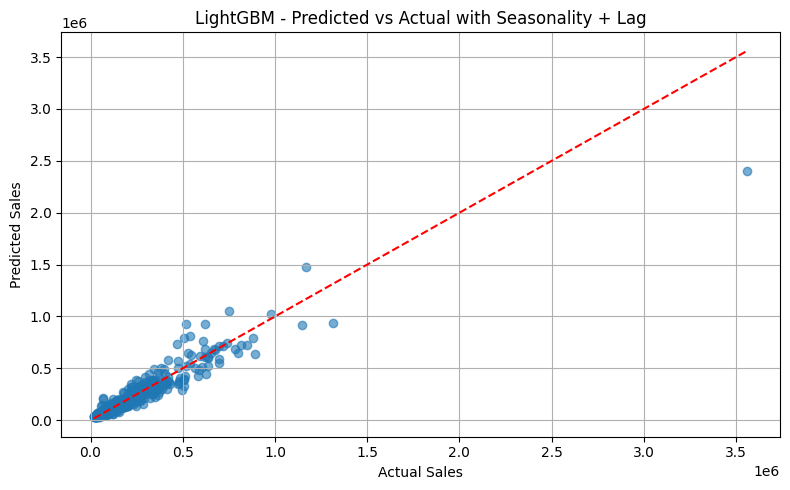

In [ ]:
# ✅ Step 1: Install LightGBM
!pip install lightgbm

# ✅ Step 2: Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# ✅ Step 3: Load your actual data
file_path = '/content/drive/My Drive/project 2 MMM/cleaned_with_spend.csv'
df = pd.read_csv(file_path)

media_channels = ['spend_facebook', 'spend_google', 'spend_affiliate','spend_email']
y = df['sales']

# ✅ Step 4: Feature engineering - Adstock + Saturation
def apply_adstock(series, decay):
    adstocked = np.zeros_like(series)
    adstocked[0] = series.iloc[0]
    for t in range(1, len(series)):
        adstocked[t] = series.iloc[t] + decay * adstocked[t-1]
    return adstocked

def apply_saturation(series, alpha, gamma):
    return (series * alpha) / (series * alpha + gamma ** alpha)

decay = 0.2
alpha = 2.0
gamma = 300

for ch in media_channels:
    df[f'{ch}_adstock'] = apply_adstock(df[ch], decay)
    df[f'{ch}_transformed'] = apply_saturation(df[f'{ch}_adstock'], alpha, gamma)

# ✅ Step 5: Add lagged sales
df['sales_lag1'] = df['sales'].shift(1)

# ✅ Step 6: Add month dummies (seasonality)
df['calendar_week'] = pd.to_datetime(df['calendar_week'])
df['month'] = df['calendar_week'].dt.month
month_dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True)
df = pd.concat([df, month_dummies], axis=1)

# ✅ Step 7: Prepare final feature set
features = [f'{ch}_transformed' for ch in media_channels] + ['sales_lag1'] + list(month_dummies.columns)
df = df.dropna()  # drop first row with NaN lag

X = df[features]
y = df['sales']

# ✅ Step 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Step 9: LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# ✅ Step 10: Model parameters (same tuning)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.03,
    'num_leaves': 40,
    'max_depth': 6,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 1.0,
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'seed': 42
}

# ✅ Step 11: Train model with callbacks
model = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)

# ✅ Step 12: Predict and evaluate
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
r2 = r2_score(y_test, y_pred)
similarity = 100 - mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"\n✅ R-squared: {r2:.4f}")
print(f"✅ Similarity (100 - MAPE): {similarity:.2f}%")

# ✅ Step 13: Plot results
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("LightGBM - Predicted vs Actual with Seasonality + Lag")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ✅ Fix for missing keys by filtering existing transformed features only
transformed_features = [f"{ch}_transformed" for ch in media_channels if f"{ch}_transformed" in model.feature_name()]
available_channels = [ch.replace("_transformed", "") for ch in transformed_features]

# ✅ Step 1: Total media spend for available channels
spend_sums = {ch: df[ch].sum() for ch in available_channels}

# ✅ Step 2: Get LightGBM feature importances
importances = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()

# ✅ Step 3: Media importances
media_importances = {
    ch: importances[feature_names.index(f"{ch}_transformed")]
    for ch in available_channels
    if f"{ch}_transformed" in feature_names
}

# ✅ Step 4: Normalize to get contribution %
total_importance = sum(media_importances.values())
contribution_pct = {ch: (imp / total_importance) * 100 for ch, imp in media_importances.items()}

# ✅ Step 5: Calculate ROI (per 1M spent)
roi = {ch: contribution_pct[ch] / spend_sums[ch] * 1_000_000 for ch in available_channels}

# ✅ Step 6: Summary DataFrame
summary_df = pd.DataFrame({
    'Media Channel': available_channels,
    'Total Spend': [spend_sums[ch] for ch in available_channels],
    'Sales Contribution (%)': [contribution_pct[ch] for ch in available_channels],
    'ROI (per million spent)': [roi[ch] for ch in available_channels]
})

# ✅ Step 7: Budget suggestion
summary_df['Suggested Budget %'] = summary_df['Sales Contribution (%)'] / summary_df['Sales Contribution (%)'].sum() * 100
summary_df = summary_df.sort_values(by='Sales Contribution (%)', ascending=False).reset_index(drop=True)

summary_df



,Media Channel,Total Spend,Sales Contribution (%),ROI (per million spent),Suggested Budget %
0,spend_google,5407431.86,41.135033,7.607129,41.135033
1,spend_facebook,1231548.82,30.119597,24.456681,30.119597
2,spend_email,2319964.45,24.342570,10.492648,24.342570
3,spend_affiliate,83866.85,4.402799,52.497494,4.402799


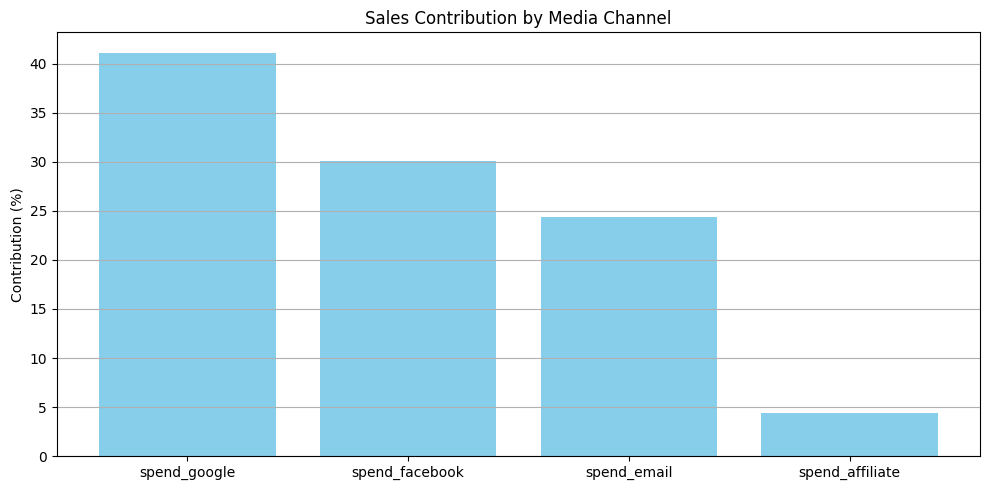

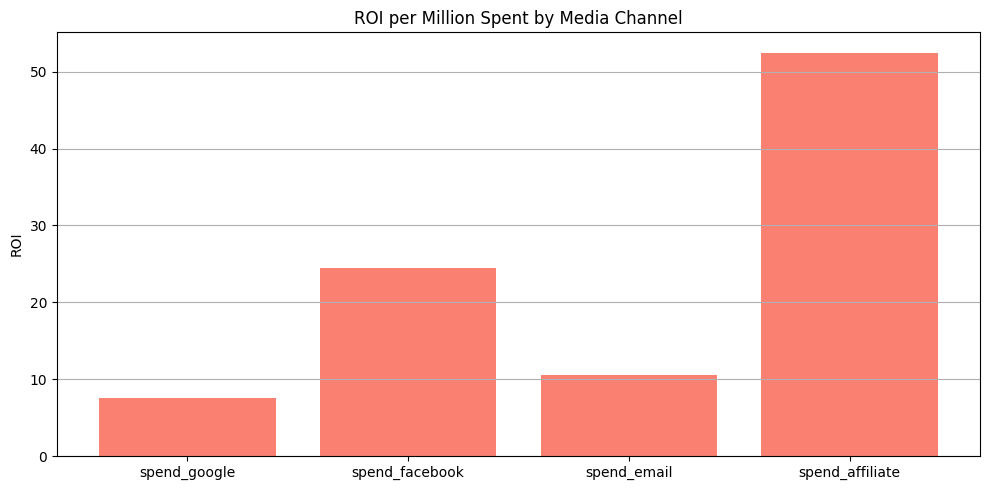

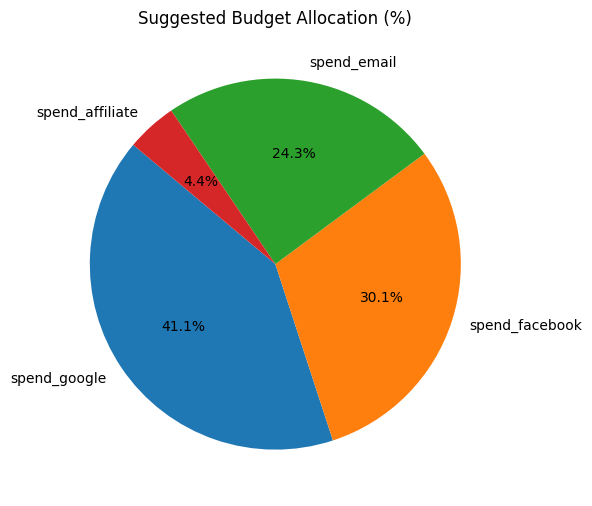

In [ ]:
# Contribution
plt.figure(figsize=(10, 5))
plt.bar(summary_df['Media Channel'], summary_df['Sales Contribution (%)'], color='skyblue')
plt.title('Sales Contribution by Media Channel')
plt.ylabel('Contribution (%)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# ROI
plt.figure(figsize=(10, 5))
plt.bar(summary_df['Media Channel'], summary_df['ROI (per million spent)'], color='salmon')
plt.title('ROI per Million Spent by Media Channel')
plt.ylabel('ROI')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Suggested Budget Allocation (Pie)
plt.figure(figsize=(6, 6))
plt.pie(summary_df['Suggested Budget %'], labels=summary_df['Media Channel'], autopct='%1.1f%%', startangle=140)
plt.title('Suggested Budget Allocation (%)')
plt.tight_layout()
plt.show()
